<a href="https://colab.research.google.com/github/roni762583/NEAT/blob/main/oanda-neat-rewrite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -f *
!pip install neat-python
#!pip install gymnasium
!pip install visualize
#!pip install pygame
!pip install plotly

#import gymnasium as gym
#import gym.spaces as spaces
import math
import pandas as pd
import requests
import numpy as np
import neat
from neat.nn import FeedForwardNetwork
from neat.population import Population
import matplotlib.pyplot as plt
import pickle
import json
import os
from datetime import datetime, timedelta
import time

rm: cannot remove 'sample_data': Is a directory


In [ ]:
instrument = "GBP_NZD"
API_KEY = "dc209942c46fbd6dd5zbe97a7043edb9-97d2222a6dfa0ef915ee92ce54628997"
ACCOUNT_ID = "001-001-5555550-001"
OANDA_URL = "https://api-fxtrade.oanda.com/v3"
inst_url = f"{OANDA_URL}/accounts/{ACCOUNT_ID}/instruments"
candles_url =  f"{OANDA_URL}/instruments/{instrument}/candles"
SECURE_HEADER = {
    'Authorization': f'Bearer {API_KEY}'
}

In [ ]:
# gets instruments info
def fetch_instrument_data(api_key, account_id, instrument_name):
    # Base OANDA API URL
    oanda_url = "https://api-fxtrade.oanda.com/v3"

    # Endpoint for instrument information
    inst_url = f"{oanda_url}/accounts/{account_id}/instruments"

    # Request headers with authorization
    headers = {
        'Authorization': f'Bearer {api_key}'
    }

    # Create a session for making requests
    session = requests.Session()

    # Make the API request to get instrument information
    inst_response = session.get(inst_url, params=None, headers=headers)

    # Check if the request was successful
    if inst_response.status_code == 200:
        # Extract instrument data from the JSON response
        inst_data = inst_response.json()

        # Extract information for the specified instrument
        instrument_info = next((item for item in inst_data['instruments'] if item['name'] == instrument_name), None)

        if instrument_info:
            # Return a dictionary with instrument information
            return {
                'name': instrument_info['name'],
                'type': instrument_info['type'],
                'displayName': instrument_info['displayName'],
                'pipLocation': instrument_info['pipLocation'],
                'marginRate': instrument_info['marginRate']
            }
        else:
            print(f"Instrument '{instrument_name}' not found.")
            return None
    else:
        print(f"Error: {inst_response.status_code}, {inst_response.text}")
        return None

In [ ]:
# get inst. info
instrument_info = fetch_instrument_data(API_KEY, ACCOUNT_ID, instrument)

if instrument_info:
    print("Instrument Info:")
    print(instrument_info)
    # Convert the instrument_info to a list before creating the DataFrame
    instrument_info_list = [instrument_info]
    instrument_df = pd.DataFrame(instrument_info_list)


Instrument Info:
{'name': 'GBP_NZD', 'type': 'CURRENCY', 'displayName': 'GBP/NZD', 'pipLocation': -4, 'marginRate': '0.05'}


In [ ]:
    # pickle Instruments data df
    instrument_df.to_pickle("instruments.pkl")
    ins_df = pd.read_pickle("instruments.pkl")

l




l

In [ ]:
# functions

def parse_candle_data_to_dataframe(json_response):
    # Define lists for prices and OHLC (Open, High, Low, Close)
    prices = ['mid', 'bid', 'ask']
    ohlc = ['o', 'h', 'l', 'c']

    # Initialize an empty list to store dictionaries
    our_data = []

    # Loop through each candle in the 'candles' list of the JSON response
    for candle in json_response['candles']:
        # Check if the candle is complete; if not, skip to the next iteration
        if candle['complete'] is False:
            continue

        # Create a new dictionary with 'time' and 'volume' as initial keys
        new_dict = {'time': candle['time'], 'volume': candle['volume']}

        # Nested loops to iterate over prices and OHLC
        for price in prices:
            for oh in ohlc:
                # Create keys in the form of 'price_ohlc' and assign corresponding values
                new_dict[f"{price}_{oh}"] = candle[price][oh]

        # Append the created dictionary to the list
        our_data.append(new_dict)

    # Convert the list of dictionaries into a pandas DataFrame
    return pd.DataFrame.from_dict(our_data)


# save file
def save_file(candles_df, pair, granularity):
    candles_df.to_pickle(f"{pair}_{granularity}.pkl")


In [ ]:

# Modified function to fetch candles based on count
def fetch_candles_count(pair_name, granularity, start_time, candles_count):
    url = candles_url

    # Format the start time
    start_time_formatted = start_time.strftime('%Y-%m-%dT%H:%M:%S')

    # Set the 'from' and 'count' parameters for the time range
    params = {
        'granularity': granularity,
        'price': 'MBA',
        'from': start_time_formatted,
        'count': candles_count
    }

    response = requests.get(url, params=params, headers=SECURE_HEADER)

    if response.status_code == 200:
        candles_data = response.json()
        return response.status_code, candles_data['candles']
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return response.status_code, None


granularity = 'H1'
start_time = datetime(2023, 10, 1, 0, 0, 0)  # Set time to midnight
candles_count = 500  # Adjust as needed

# Fetch candles based on count
status_code, candles_data = fetch_candles_count(instrument, granularity, start_time, candles_count)

if status_code != 200:
    print(f"{instrument} Error: {status_code}")
else:
    # Process candles_data as needed
    candles_df = parse_candle_data_to_dataframe({'candles': candles_data})
    save_file(candles_df, instrument, granularity)


In [ ]:
# this worked
print(candles_df.head())

                             time  volume    mid_o    mid_h    mid_l    mid_c  \
0  2023-10-01T21:00:00.000000000Z      85  2.03445  2.03695  2.03425  2.03466   
1  2023-10-01T22:00:00.000000000Z    2033  2.03488  2.03538  2.03262  2.03320   
2  2023-10-01T23:00:00.000000000Z    1434  2.03316  2.03420  2.03270  2.03358   
3  2023-10-02T00:00:00.000000000Z    2215  2.03360  2.03460  2.03239  2.03424   
4  2023-10-02T01:00:00.000000000Z    3720  2.03430  2.03532  2.03340  2.03372   

     bid_o    bid_h    bid_l    bid_c    ask_o    ask_h    ask_l    ask_c  
0  2.03195  2.03445  2.03175  2.03272  2.03695  2.03945  2.03591  2.03661  
1  2.03322  2.03484  2.03083  2.03287  2.03655  2.03659  2.03299  2.03353  
2  2.03284  2.03384  2.03236  2.03306  2.03349  2.03456  2.03304  2.03411  
3  2.03309  2.03427  2.03202  2.03387  2.03411  2.03495  2.03272  2.03461  
4  2.03391  2.03498  2.03300  2.03340  2.03468  2.03566  2.03377  2.03403  


In [ ]:
# read pickle and copy columns
fn = instrument+'_'+granularity+'.pkl'
df = pd.read_pickle(fn)
neat_df = df[['time', 'bid_c']].copy()
# Convert 'time' column to datetime in 'neat_df'
neat_df['time'] = pd.to_datetime(neat_df['time'])
# Remove time zone from the 'time' column in neat_df
neat_df['time'] = neat_df['time'].dt.tz_localize(None)


In [ ]:
print(neat_df.shape)
print(neat_df.head())
print(neat_df.tail())

(500, 2)
                 time    bid_c
0 2023-10-01 21:00:00  2.03272
1 2023-10-01 22:00:00  2.03287
2 2023-10-01 23:00:00  2.03306
3 2023-10-02 00:00:00  2.03387
4 2023-10-02 01:00:00  2.03340
                   time    bid_c
495 2023-10-30 12:00:00  2.08105
496 2023-10-30 13:00:00  2.08004
497 2023-10-30 14:00:00  2.08122
498 2023-10-30 15:00:00  2.08302
499 2023-10-30 16:00:00  2.08317


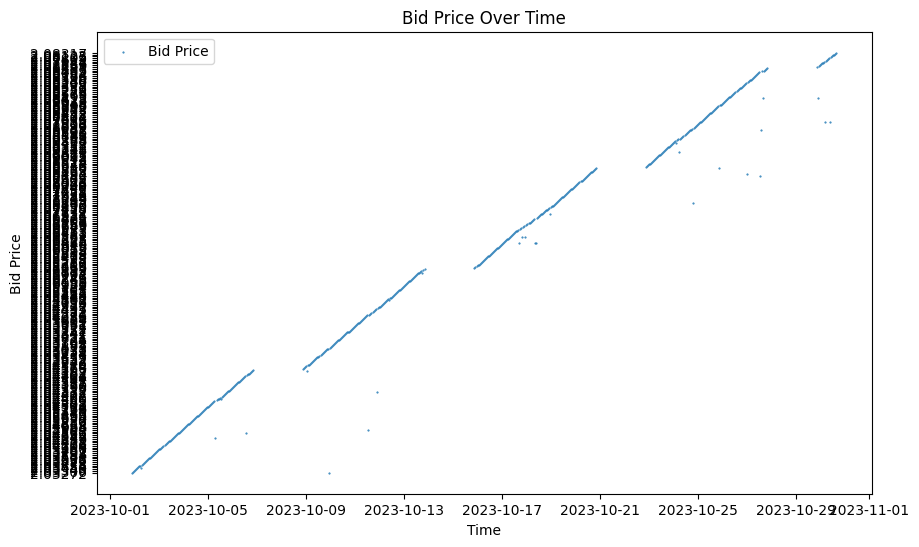

In [ ]:
import matplotlib.pyplot as plt

# Plotting the 'bid_c' column over time with small points
plt.figure(figsize=(10, 6))
plt.scatter(neat_df['time'], neat_df['bid_c'], marker='.', s=1, label='Bid Price')  # 's' controls the marker size
plt.title('Bid Price Over Time')
plt.xlabel('Time')
plt.ylabel('Bid Price')

# Reduce the number of labels on the y-axis
plt.yticks(plt.yticks()[0][::2])  # Adjust the step value as needed

plt.legend()
plt.show()


In [ ]:

# Define the start and end date for the subset
start_date = '2022-01-03 00:00:00'
end_date = '2022-01-04 12:00:00'

# Convert the date strings to datetime objects
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Create a subset of neat_df based on the specified date range
subset_df = neat_df[(neat_df['time'] >= start_date) & (neat_df['time'] <= end_date)]

# Make a deep copy of the subset dataframe
subset_copy = subset_df.copy()

# Print the shape of the subset dataframe and its deep copy
print(f"Subset DataFrame shape: {subset_df.shape}")
print(f"Deep Copy shape: {subset_copy.shape}")


Subset DataFrame shape: (0, 2)
Deep Copy shape: (0, 2)


In [ ]:
import plotly.express as px

# Convert 'time' column to string for better hover labels
subset_copy['time_str'] = subset_copy['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Plotting the 'bid_c' column over time with plotly
fig = px.line(subset_copy, x='time', y='bid_c', labels={'bid_c': 'Bid Price'}, title='Bid Price Over Time')
fig.update_xaxes(title_text='Time', rangeslider_visible=True)
fig.update_yaxes(title_text='Bid Price')
fig.update_traces(hovertemplate='Date: %{x|%Y-%m-%d %H:%M:%S}<br>Bid Price: %{y}')

# Show the interactive chart
fig.show()


In [ ]:
!pip install wget
import pandas as pd
import wget
import pandas as pd

# Replace 'URL' with the actual URL of the CSV file
url = 'https://raw.githubusercontent.com/roni762583/AUDJPY-1M/main/DAT_ASCII_AUDJPY_M1_2020.csv'

# Read the CSV file with ';' as the delimiter
df = pd.read_csv(url, sep=';', header=None, names=['DateTime', 'Open', 'High', 'Low', 'close_bid','vol'], parse_dates=True)
df = df.drop(columns=['Open', 'High', 'Low', 'vol'])
# Display the first few rows of the DataFrame
print(df.head())


In [ ]:
# using three button output

# Assuming softmax_output contains the output probabilities from the softmax layer
softmax_output = np.array([0.2, 0.3, 0.5])

# Set a threshold for interpreting "no action"
threshold = 0.4

# Interpret the output
if np.max(softmax_output) > threshold:
    action = np.argmax(softmax_output)
    if action == 0:
        print("Buy")
    elif action == 1:
        print("Sell")
    else:
        print("Close")
else:
    print("Hold")


Close
